# Objectif de ce notebook
1. Modéliser le comportement des items dans Dofus, les caractéristiques des items et leurs limites
2. Introduire les notions de forgemagie et la modification des caractéristiques initiales
3. Générer aléatoirement des patternes d'item avec les valeurs min, max des stats de l'item
4. Générer des items à partir patternes d'item avec des stats réelles
5. Evaluer ces items selon un algorithme de base
6. Remplir un dataframe avec ces items et en faire un fichier.csv que l'on va étudier et soumettre à un modèle de ML pour prédire la qualité

# Importer toutes les libraries nécessaires avec la cellule suivante

In [1]:
import numpy as np
import pandas as pd
import random
import string

# ****1. Définition d'un item et de ses caractéristiques****
## Objectifs
- Définir ce qu'est un item, ses caractéristiques, les valeures théoriques maximales et minimales
- Créer une classe ItemTemplate qui décrit un patterne d'item selon ses valeures théoriques
- Créer une classe ItemInstance qui définit les valeures réelles de l'item
- Stocker chaque type de caractéristique du jeu dans un dictionnaire
- Créer des fonctions qui évaluent mon item de façon brève afin de simuler une récupération de données manuellement
- Créer une fontion qui peut générer des items aléatoirement
## 1.1. Définition de la classe StatDefinition
Définit une statistique de base d'un item, avec sa valeur minimale, maximale théorique

In [2]:
class StatDefinition:
    def __init__(self, name, min_value, max_value, type="fixe", weight=1):
        self.name = name
        self.min_value = min_value
        self.max_value = max_value
        self.type = type
        self.weight = weight

    def __repr__(self):
        return f"{self.name} ({self.min_value}-{self.max_value}, poids={self.weight})"

## 1.2. Dictionnaire stat_pool
Dictionnaire des statistiques du jeu

In [3]:
stat_pool = {
    "vitalité": StatDefinition("vitalité", 0, 505, weight=0.2),
    "sagesse": StatDefinition("sagesse", 0, 60, weight=3),
    "force": StatDefinition("force", 0, 101, weight=1),
    "chance": StatDefinition("chance", 0, 101, weight=1),
    "agilité": StatDefinition("agilité", 0, 101, weight=1),
    "intelligence": StatDefinition("intelligence", 0, 101, weight=1),
    "dommage": StatDefinition("dommages", 0, 20, weight=20),
    "dommage_neutre" : StatDefinition("dommage_neutre", 0, 20, weight = 5),
    "dommage_terre" : StatDefinition("dommage_terre", 0, 20, weight = 5),
    "dommage_feu" : StatDefinition("dommage_feu", 0, 20, weight = 5),
    "dommage_eau" : StatDefinition("dommage_eau", 0, 20, weight = 5),
    "dommage_air" : StatDefinition("dommage_air", 0, 20, weight = 5),
    "dommage_critique" : StatDefinition("dommage_critique", 0, 25, weight = 5),
    "puissance": StatDefinition("puissance", 0, 100, weight=2),
    "coups_critiques": StatDefinition("coups_critiques", 0, 10, weight=10),
    "invocation": StatDefinition("invocation", 0, 2, weight=30),
    "résistance_neutre": StatDefinition("résistance_neutre", 0, 25, weight=2),
    "résistance_terre": StatDefinition("résistance_terre", 0, 25, weight=2),
    "résistance_feu": StatDefinition("résistance_feu", 0, 25, weight=2),
    "résistance_eau": StatDefinition("résistance_eau", 0, 25, weight=2),
    "résistance_air": StatDefinition("résistance_air", 0, 25, weight=2),
    "résistance_poussée": StatDefinition("résistance_poussée", 0, 80, weight=2),
    "résistance_critique": StatDefinition("résistance_critique", 0, 40, weight=2),
    "résistance_neutre_%": StatDefinition("résistance_neutre_%", 0, 15, weight=6),
    "résistance_terre_%": StatDefinition("résistance_terre_%", 0, 15, weight=6),
    "résistance_feu_%": StatDefinition("résistance_feu_%", 0, 15, weight=6),
    "résistance_eau_%": StatDefinition("résistance_eau_%", 0, 15, weight=6),
    "résistance_air_%": StatDefinition("résistance_air_%", 0, 15, weight=6),
    "tacle": StatDefinition("tacle", 0, 20, weight=4),
    "fuite": StatDefinition("fuite", 0, 20, weight=4),
    "soin": StatDefinition("soins", 0, 30, weight=10),
    "PA": StatDefinition("PA", 0, 1, weight=100),
    "PM": StatDefinition("PM", 0, 1, weight=90),
    "PO": StatDefinition("PO", 0, 2, weight=51),
    "prospection": StatDefinition("prospection", 0, 33, weight=3),
    "initiative": StatDefinition("initiative", 0, 800, weight=0.1),
    "pods": StatDefinition("pods", 0, 2000, weight=0.25),
    "dommage_dist_%" : StatDefinition("dommage_dist_%", 0, 5, weight=15),
    "dommage_sort_%" : StatDefinition("dommage_sort_%", 0, 5, weight=15),
    "dommage_mêlee_%" : StatDefinition("dommage_mêlee_%", 0, 5, weight=15),
    "résistance_dist_%" : StatDefinition("résistance_dist_%", 0, 5, weight=15),
    "résistance_sort_%" : StatDefinition("résistance_sort_%", 0, 5, weight=15),
    "résistance_melee_%" : StatDefinition("résistance_melee_%", 0, 5, weight=15)
}

## 1.3. Classe ItemTemplate
Sert à générer un patterne d'item, les statistiques de base d'un item, jets théoriques min et max

In [4]:
class ItemTemplate:
    def __init__(self, name, stats, pui_category="moyen"):
        self.name = name
        self.stats = stats
        self.pui_category = pui_category

    def get_stat_max(self, stat_name):
        return self.stats.get(stat_name).max_value if stat_name in self.stats else 0

    def get_stat_weight(self, stat_name):
        return self.stats.get(stat_name).weight if stat_name in self.stats else 0

    def has_stat(self, stat_name):
        return stat_name in self.stats

## 1.4. Class ItemInstance
Définit un Item avec ses statistiques réelles en tenant compte de celles du patterne

In [5]:
class ItemInstance:
    def __init__(self, template, current_stats, label=None):
        self.template = template
        self.current_stats = current_stats
        self.label = label

    def get_ratio(self, stat):
        base = self.template.get_stat_max(stat)
        val = self.current_stats.get(stat, 0)
        if base <= 0:
            return np.nan
        return val / base

    def is_over(self, stat):
        ratio = self.get_ratio(stat)
        return ratio > 1 if not np.isnan(ratio) else False

    def is_exo(self, stat):
        return stat not in self.template.stats and self.current_stats.get(stat, 0) > 0

    def get_total_weight(self):
        weight = 0
        for stat in self.template.stats:
            value = min(self.current_stats.get(stat, 0), self.template.get_stat_max(stat))
            weight += value * self.template.get_stat_weight(stat)
        return weight

    def get_exo_weight(self):
        weight = 0
        for stat in self.current_stats:
            if self.is_exo(stat) and stat in stat_pool:
                weight += self.current_stats[stat] * stat_pool[stat].weight
        return weight


    def get_features(self):
        ratios = {f"{stat}_ratio": self.get_ratio(stat) for stat in self.template.stats}
        overs = sum(1 for stat in self.template.stats if self.is_over(stat))
        exos = sum(1 for stat in self.current_stats if self.is_exo(stat))
        total_weight = self.get_total_weight()
        exo_weight = self.get_exo_weight()
        perfect_lines = sum(
            1 for stat in self.template.stats
            if self.current_stats.get(stat, 0) == self.template.get_stat_max(stat)
        )

        features = {
            "item_name": self.template.name,
            "pui_category": self.template.pui_category,
            "nb_stats": len(self.template.stats),
            "nb_overs": overs,
            "nb_exos": exos,
            "nb_perfect_lines": perfect_lines,
            "total_weight": total_weight,
            "exo_weight": exo_weight,
            **ratios
        }
        return features

    def get_clean_features(self):
        perfect_lines = sum(
            1 for stat in self.template.stats
            if self.current_stats.get(stat, 0) == self.template.get_stat_max(stat)
        )

        high_ratios = sum(
            1 for stat in self.template.stats
            if 0.9 < self.get_ratio(stat) < 1
        )

        is_exo = self.get_exo_weight() > 0
        is_over = any(self.is_over(stat) for stat in self.template.stats)

        over_weight = sum(
            (self.current_stats[stat] - self.template.get_stat_max(stat)) * self.template.get_stat_weight(stat)
            for stat in self.template.stats
            if self.is_over(stat)
        )

        return {
            "nb_stats": len(self.template.stats),
            "nb_perfect_lines": perfect_lines,
            "nb_high_ratio": high_ratios,
            "total_weight": self.get_total_weight(),
            "is_exo": is_exo,
            "exo_weight": self.get_exo_weight(),
            "is_over": is_over,
            "over_weight": over_weight,
            "pui_category": self.template.pui_category
        }
    
    def evaluate_quality_algo(self):
        malus = 0
        total_score = 100
        exo = self.get_exo_weight() > 0
        over = any(self.is_over(stat) for stat in self.template.stats)

        if any(stat in self.template.stats for stat in ["PA", "PM","PO"]):
            puit = "grand"
        elif any(stat in self.template.stats for stat in ["invocation", "coups_critiques"]) or \
             ("sagesse" in self.template.stats and self.template.get_stat_max("sagesse") >= 40):
            puit = "moyen"
        else:
            puit = "faible"

        essential_stats = {
            "PA", "PM", "PO", "invocation",
            "résistance_neutre_%", "résistance_terre_%", "résistance_feu_%", "résistance_eau_%", "résistance_air_%",
            "résistance_neutre", "résistance_terre", "résistance_feu", "résistance_eau", "résistance_air",
            "coups_critiques", "résistance_critique", "résistance_poussée"
        }

        for stat in essential_stats:
            if stat in self.template.stats and self.get_ratio(stat) < 1:
                malus += 20

        for stat in self.template.stats:
            if stat in essential_stats:
                continue
            ratio = self.get_ratio(stat)
            if np.isnan(ratio):
                continue
            max_val = self.template.get_stat_max(stat)
            val = self.current_stats.get(stat, 0)

            if stat in {"force", "chance", "intelligence", "agilité"}:
                if max_val < 60 and (max_val - val) > 2:
                    malus += 5
                elif max_val >= 100 and (max_val - val) > 9:
                    malus += 5
            elif stat == "vitalité" and (max_val - val) > 5:
                malus += 5
            elif stat == "initiative" and (max_val - val) > 9:
                malus += 5
            elif stat == "sagesse":
                if max_val == 40 and (max_val - val) > 3:
                    malus += 5
                elif max_val == 50 and (max_val - val) > 5:
                    malus += 5
                elif max_val == 60 and (max_val - val) > 10:
                    malus += 5
            elif stat in {"tacle", "fuite"} and val < 0.7 * max_val:
                malus += 5
            else:
                if ratio < 0.9:
                    malus += 3

        note = max(0, total_score - malus)
        return {"note": note, "exo": exo, "over": over, "puit": puit}

## 1.5. Fonction classify_pui(stats)
Fonction qui classify les items selon leur poids de base

In [6]:
def classify_pui(stats):
    if any(stat in stats for stat in ["PA", "PM", "PO"]):
        return "grand"
    if ("invocation" in stats or
        ("sagesse" in stats and stats["sagesse"].max_value > 40) or
        ("coups_critiques" in stats and stats["coups_critiques"].max_value > 4) or
        any(stat.startswith("dommage") for stat in stats)):
        return "moyen"
    return "faible"

## 1.6. Fonction generate_random_template()
Fonction qui génère un template d'item théorique

In [7]:
def generate_random_template():
    name = "Item_" + ''.join(random.choices(string.ascii_uppercase, k=5))
    stats = {}

    # Stat commune : sagesse (90% de chance)
    if random.random() < 0.9:
        definition = stat_pool["sagesse"]
        stats["sagesse"] = StatDefinition("sagesse", 20, 60, weight=definition.weight)

    # Stat très fréquente : vitalité
    definition = stat_pool["vitalité"]
    stats["vitalité"] = StatDefinition("vitalité", 100, 400, weight=definition.weight)

    # Coups critiques (1 chance sur 2, max 7)
    if random.random() < 0.5:
        definition = stat_pool["coups_critiques"]
        stats["coups_critiques"] = StatDefinition("coups_critiques", 1, 7, weight=definition.weight)

    # Stats élémentaires (90% de chance d'en avoir au moins une)
    elem_stats = ["force", "intelligence", "chance", "agilité"]
    if random.random() < 0.9:
        selected_elem = random.sample(elem_stats, k=random.choice([1, 2]))
        for elem in selected_elem:
            definition = stat_pool[elem]
            max_val = random.choice([v for v in range(30, definition.max_value + 1, 5)])
            min_val = max(5, int(max_val * 0.5))
            min_val -= min_val % 5
            stats[elem] = StatDefinition(elem, min_val, max_val, weight=definition.weight)

            # Associer une stat de dommage à l'élément
            elem_dmg = f"dommage_{elem}" if f"dommage_{elem}" in stat_pool else "dommage"
            if elem_dmg in stat_pool:
                dmg_def = stat_pool[elem_dmg]
                stats[elem_dmg] = StatDefinition(elem_dmg, 3, dmg_def.max_value, weight=dmg_def.weight)

    # Résistances (1 chance sur 2 d'en avoir une)
    resistance_stats = [s for s in stat_pool if "résistance" in s and s not in stats]
    if random.random() < 0.5 and resistance_stats:
        stat = random.choice(resistance_stats)
        definition = stat_pool[stat]
        stats[stat] = StatDefinition(stat, 3, definition.max_value, weight=definition.weight)

    # Ajout aléatoire de 1 à 3 autres stats restantes
    remaining = [s for s in stat_pool if s not in stats and stat_pool[s].max_value > 0]
    for stat in random.sample(remaining, k=random.randint(1, 3)):
        definition = stat_pool[stat]
        max_cap = definition.max_value
        if max_cap >= 30:
            max_val = random.choice([v for v in range(30, max_cap + 1, 5)])
        else:
            max_val = random.randint(1, max_cap)
        min_val = max(5, int(max_val * 0.5))
        min_val -= min_val % 5
        stats[stat] = StatDefinition(stat, min_val, max_val, weight=definition.weight)

    # Détermination automatique du puit
    if any(stat in stats for stat in ["PA", "PM", "PO"]):
        pui_category = "gros"
    elif any(stat in stats for stat in ["invocations", "coups_critiques"]) or ("sagesse" in stats and stats["sagesse"].max_value >= 40):
        pui_category = "moyen"
    else:
        pui_category = "faible"

    return ItemTemplate(name, stats, pui_category=pui_category)

## 1.7. Fonction generate_random_instance(template)
Fonction qui génère aléatoirement des instances d'items à partir d'un template

In [8]:
def generate_random_instance(template):
    exo_types = []
    current_stats = {}
    elemental_stats = {"force", "intelligence", "chance", "agilité", "sagesse", "vitalité"}

    for stat, definition in template.stats.items():
        if stat in elemental_stats:
            val = random.choice([v for v in range(int(definition.max_value * 0.6), definition.max_value + 1, 5)])
        elif stat in {"coups_critiques", "PA", "PM", "PO", "invocations"} or "résistance_" in stat:
            if random.random() < 0.8:
                val = definition.max_value
            else:
                val = random.randint(int(definition.max_value * 0.6), definition.max_value)
        elif "dommage" in stat:
            if definition.max_value > 11:
                val = random.choice([definition.max_value - 1, definition.max_value]) if random.random() < 0.8 else random.randint(int(definition.max_value * 0.6), definition.max_value - 2)
            else:
                val = random.randint(int(definition.max_value * 0.6), definition.max_value)
        else:
            val = random.randint(int(definition.max_value * 0.6), definition.max_value)
        current_stats[stat] = val

    if any(stat in template.stats for stat in ["PA", "PM", "PO"]):
        puit = "gros"
    elif any(stat in template.stats for stat in ["invocation", "coups_critiques"]) or ("sagesse" in template.stats and template.get_stat_max("sagesse") >= 40):
        puit = "moyen"
    else:
        puit = "faible"

    if puit == "gros":
        max_exo_weight = 101
        exo_candidates = ["PA", "PM", "PO"] + [s for s in stat_pool if s not in template.stats and stat_pool[s].weight <= 50]
    elif puit == "moyen":
        max_exo_weight = 50
        exo_candidates = ["PA", "PM", "PO"] + [s for s in stat_pool if s not in template.stats and stat_pool[s].weight <= 30]
    else:
        max_exo_weight = 20
        exo_candidates = [s for s in stat_pool if s not in template.stats and stat_pool[s].weight <= 15]

    random.shuffle(exo_candidates)
    total_exo_weight = 0

    for exo_stat in exo_candidates:
        is_major_exo = exo_stat in ["PA", "PM", "PO"]
        chance = 0.5 if not is_major_exo and not exo_types else 0.01

        if random.random() < chance:
            definition = stat_pool[exo_stat]
            max_val = definition.max_value
            exo_val = random.randint(1, max_val)
            added_weight = exo_val * definition.weight

            if total_exo_weight + added_weight <= max_exo_weight:
                current_stats[exo_stat] = exo_val
                exo_types.append("majeur" if is_major_exo else "classique")
                total_exo_weight += added_weight * 2

    instance = ItemInstance(template, current_stats)
    instance.exo_types = exo_types
    return instance

# ****2. Création d'un jeu de données artificielles****
## 2.1. Fonction generate_dataset(nb_templates, nb_instance_per_case)
Création d'un dataset selon le nombre de templates, et nombre d'instances par template

In [9]:
def generate_dataset(nb_templates=100, nb_instances_per_case=50):
    dataset = []
    templates = [generate_random_template() for _ in range(nb_templates)]
    for template in templates:
        puit = template.pui_category

        for case in ["exo", "over", "rien"]:
            for _ in range(nb_instances_per_case):
                instance = generate_random_instance(template)

                # Forcer comportement selon le cas voulu
                if case == "rien":
                    # Supprimer exos
                    instance.current_stats = {
                        stat: val for stat, val in instance.current_stats.items()
                        if stat in template.stats
                    }
                elif case == "exo":
                    # Ajouter un exo forcé si aucun
                    if instance.get_exo_weight() == 0:
                        candidates = [s for s in stat_pool if s not in template.stats and stat_pool[s].weight <= 50]
                        if candidates:
                            stat = random.choice(candidates)
                            instance.current_stats[stat] = random.randint(1, stat_pool[stat].max_value)

                elif case == "over":
                    # Ajouter un over forcé si aucun
                    over_candidates = [s for s in template.stats]
                    if over_candidates:
                        stat = random.choice(over_candidates)
                        instance.current_stats[stat] = instance.current_stats.get(stat, 0) + random.randint(1, 5)

                features = instance.get_clean_features()
                features["note"] = instance.evaluate_quality_algo()["note"]
                features["template_name"] = template.name
                features["config_case"] = f"{puit}_pui_{case}"
                dataset.append(features)

    return pd.DataFrame(dataset)

## 2.2. Génération du dataset
- Une fois généré ne plus exécuter ou commenter
- Si dataset pas assez pertinent, regénerer et refaire les tests (voir partie 3)

In [10]:
import os

dataset = generate_dataset()

# Détection automatique de l’environnement Kaggle
running_on_kaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is not None

if running_on_kaggle:
    # Environnement Kaggle : enregistrer à la racine (pour apparaître dans "Output")
    dataset.to_csv("item_dataset.csv", index=False)
else:
    # Environnement local : dossier structuré
    os.makedirs("../data/processed", exist_ok=True)
    dataset.to_csv("../data/processed/item_dataset.csv", index=False)

# 3. ****Etude de fiabilité du fichier item_dataset.csv****
### Objectif :
- S'assurer que le jeu de données est assez pertinent pour pouvoir entrainer un modèle de ML
- S'assurer qu'il y ait assez d'items de chaque catégorie
- Checkez la distribution des notes
- Regardez les corrélations entre features
- Analyse par catégorie de puits
- Utiliser des modèles simples pour tester

## Afficher les premières lignes du dataset

In [11]:
df = pd.read_csv("data/processed/item_dataset.csv")
df.head()

,nb_stats,nb_perfect_lines,nb_high_ratio,total_weight,is_exo,exo_weight,is_over,over_weight,pui_category,note,template_name,config_case
0,6,2,0,770.0,True,38.0,False,0.0,moyen,85,Item_QIEOY,moyen_pui_exo
1,6,2,2,811.0,True,22.0,False,0.0,moyen,90,Item_QIEOY,moyen_pui_exo
2,6,2,2,753.0,True,36.0,False,0.0,moyen,85,Item_QIEOY,moyen_pui_exo
3,6,0,2,721.0,True,15.0,False,0.0,moyen,65,Item_QIEOY,moyen_pui_exo
4,6,3,2,780.0,True,50.0,False,0.0,moyen,90,Item_QIEOY,moyen_pui_exo


## Checker grossièrement avec describe()

In [12]:
df.describe()

,nb_stats,nb_perfect_lines,nb_high_ratio,total_weight,exo_weight,over_weight,note
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7.140000,2.281467,1.149067,765.480533,20.673900,5.995233,81.726467
std,1.435457,1.249939,0.971378,198.824300,20.865271,29.680627,11.409922
min,4.000000,0.000000,0.000000,116.000000,0.000000,0.000000,19.000000
25%,6.000000,1.000000,0.000000,701.000000,0.000000,0.000000,75.000000
50%,7.000000,2.000000,1.000000,798.000000,16.000000,0.000000,85.000000
75%,8.000000,3.000000,2.000000,880.000000,35.200000,0.000000,90.000000
max,10.000000,7.000000,5.000000,1424.750000,100.000000,500.000000,100.000000


## 3.1. Taille du dataset

In [13]:
df.shape

(15000, 12)

## 3.2 Balance des classes

In [14]:
df["config_case"].value_counts(normalize=True)

moyen_pui_exo      0.256667
moyen_pui_over     0.256667
moyen_pui_rien     0.256667
gros_pui_exo       0.063333
gros_pui_over      0.063333
gros_pui_rien      0.063333
faible_pui_exo     0.013333
faible_pui_over    0.013333
faible_pui_rien    0.013333
Name: config_case, dtype: float64

## 3.3. Distribution des notes
### 3.3.1. Distribution globale

Text(0.5, 0, 'Note de qualité')

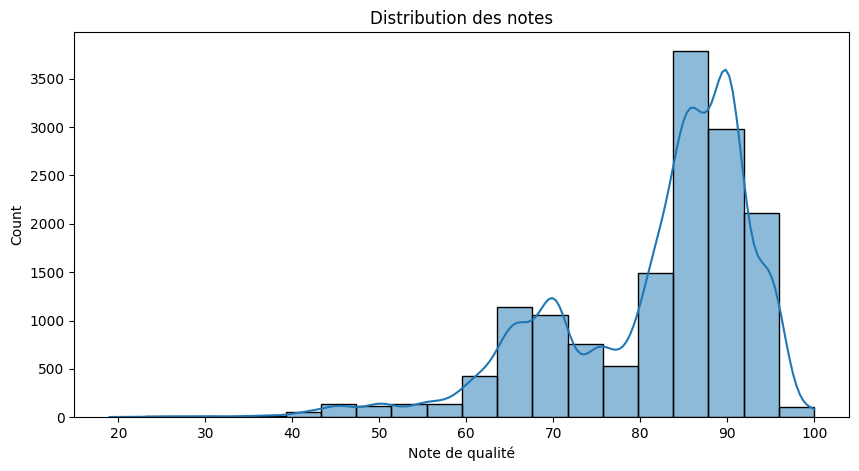

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df["note"], bins=20, kde=True)
plt.title("Distribution des notes")
plt.xlabel("Note de qualité")

### 3.3.2. Distribution des notes par catégorie de puits

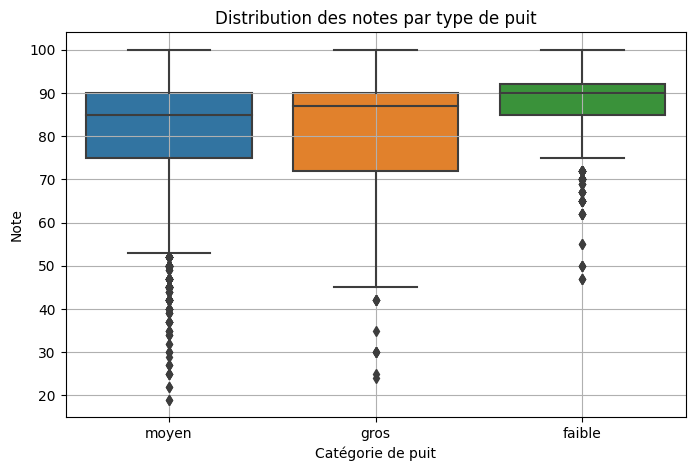

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="pui_category", y="note")
plt.title("Distribution des notes par type de puit")
plt.xlabel("Catégorie de puit")
plt.ylabel("Note")
plt.grid(True)
plt.show()

## 3.4. Corrélation entre features

<Axes: >

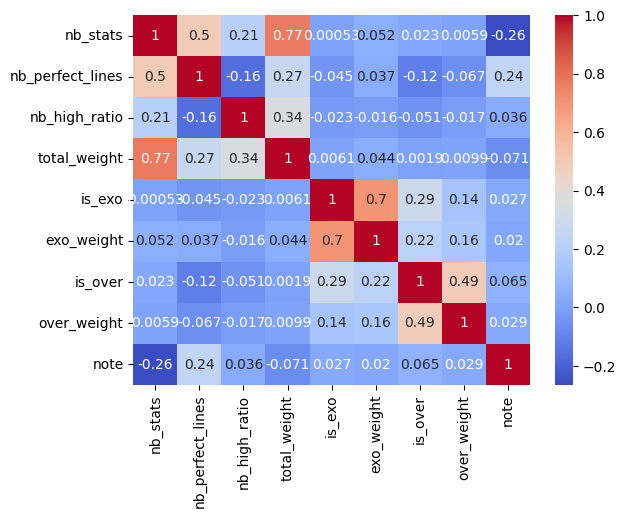

In [17]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")

### 3.4.1. Corrélation note <-> stats parfaites

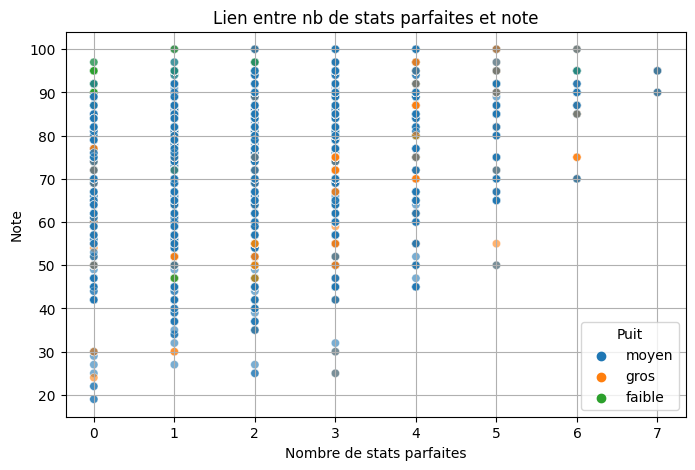

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="nb_perfect_lines", y="note", hue="pui_category", alpha=0.6)
plt.title("Lien entre nb de stats parfaites et note")
plt.xlabel("Nombre de stats parfaites")
plt.ylabel("Note")
plt.legend(title="Puit")
plt.grid(True)
plt.show()

## 3.5. Analyse par catégorie de puits

In [19]:
df.groupby("pui_category")["note"].mean()

pui_category
faible    85.843333
gros      81.932982
moyen     81.461645
Name: note, dtype: float64

# ****4. Modélisation et prédiction****
## Objectifs
- Déterminer le modèle le plus adéquate pour prédire la note d'un item
- Tester plusieurs modèles, les évaluer et garder le meilleur modèle

## 4.1. Modèles de regression
## 4.1.1. RandomForestRegressor

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Génération des données
df = generate_dataset()

# 2. Sélection des variables numériques
features = ["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight"]
target = "note"

X = df[features]
y = df[target]

# 3. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Prédictions
y_pred = model.predict(X_test)

# 6. Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.3f}")

RMSE : 8.75
R² : 0.368


## 4.1.2. GradientBoostingRegressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Générer les données
df = generate_dataset()

# Features utilisées pour l'entraînement
features = ["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight"]
target = "note"

X = df[features]
y = df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"GradientBoostingRegressor → RMSE : {rmse:.2f}")
print(f"GradientBoostingRegressor → R² : {r2:.3f}")

GradientBoostingRegressor → RMSE : 8.78
GradientBoostingRegressor → R² : 0.448


### 4.1.3. Bilan des modèles de regression
On remarque que pour les deux premiers modèles, le RMSE semble correcte mais l'indicateur R2 semble indiquer que les  modèles ne prédisent pas correctement le comportement souhaité

On va donc vérifier l'importance des features au sein du dataset

In [22]:
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f"{feat} : {imp:.3f}")


nb_stats : 0.461
nb_perfect_lines : 0.279
nb_high_ratio : 0.054
total_weight : 0.158
exo_weight : 0.018
over_weight : 0.031


On remarque que le nb_perfect_lines joue un grand rôle dans l'évaluation ce qui est normal
Il faut donc trouver une alternative pour enrichir les features ou simplifier la prédiction

Remarque : essayons de classifier nos résultats afin de faire de la classification

## 4.2. Modèle par classification
## 4.2.1. RandomForestClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.47      0.43      0.45       591
    jet moyen       0.48      0.49      0.49       981
  jet parfait       0.67      0.09      0.16        22
 très bon jet       0.68      0.71      0.69      1389

     accuracy                           0.57      3000
    macro avg       0.46      0.34      0.36      3000
 weighted avg       0.57      0.57      0.57      3000

Matrice de confusion :
[[  0   0   4   0  13]
 [  1 256 219   0 115]
 [  1 178 479   0 323]
 [  1   0   1   2  18]
 [  6 113 285   1 984]]


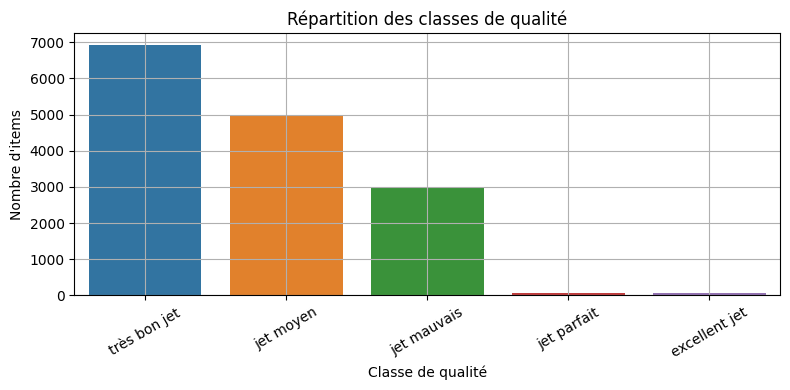

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On remarque qu'il y a beaucoup trop d'item avec un très bon jet.

On va rééquilibrer le modèle pour qu'il se foacalise davantage sur les classes minoritaires

## 4.2.2. RandomForestClassifier Balanced

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.45      0.43      0.44       591
    jet moyen       0.49      0.49      0.49       981
  jet parfait       0.50      0.05      0.08        22
 très bon jet       0.68      0.70      0.69      1389

     accuracy                           0.57      3000
    macro avg       0.42      0.33      0.34      3000
 weighted avg       0.57      0.57      0.57      3000

Matrice de confusion :
[[  0   0   4   0  13]
 [  0 256 219   0 116]
 [  1 186 479   0 315]
 [  1   0   2   1  18]
 [  5 123 283   1 977]]


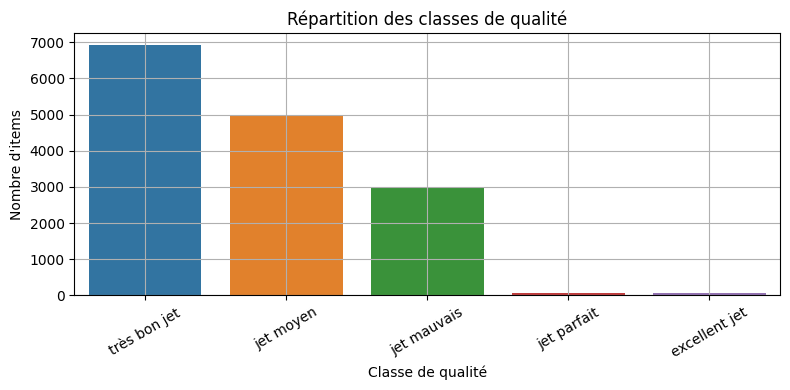

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.2.3. GradientBoostingClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00        17
  jet mauvais       0.60      0.39      0.47       591
    jet moyen       0.51      0.53      0.52       981
  jet parfait       0.71      0.23      0.34        22
 très bon jet       0.69      0.79      0.74      1389

     accuracy                           0.62      3000
    macro avg       0.50      0.39      0.42      3000
 weighted avg       0.61      0.62      0.61      3000

Matrice de confusion :
[[   0    0    1    0   16]
 [   0  228  257    0  106]
 [   0  108  524    0  349]
 [   0    0    0    5   17]
 [   2   45  237    2 1103]]


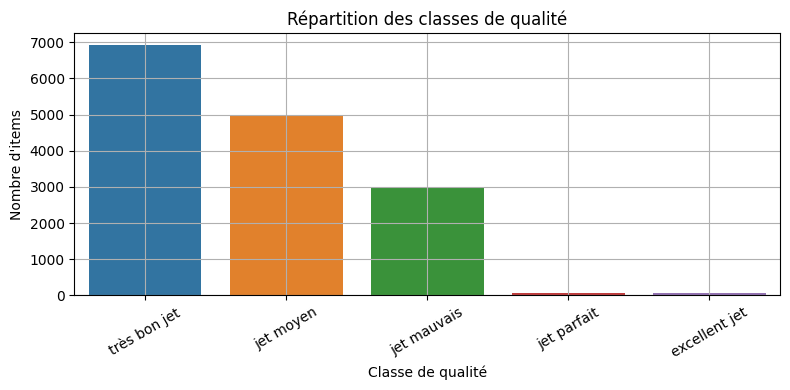

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On va simplifier la classification

## 4.2.4. GradientBoostingClassifier simplified classes

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 90:
        return "très bon jet"
    elif note > 75:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Ajout des features dérivées manquantes
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight",
             "exo_weight", "over_weight", "perfect_ratio",
             "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)
clf.fit(df_train, y_train)

# Prédiction
y_pred = clf.predict(df_test)

# Évaluation
print("Classification Report (simplifié) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Classification Report (simplifié) :
              precision    recall  f1-score   support

 jet mauvais       0.56      0.42      0.48       733
   jet moyen       0.67      0.80      0.73      1692
 jet parfait       0.39      0.32      0.35        22
très bon jet       0.60      0.45      0.51       553

    accuracy                           0.64      3000
   macro avg       0.55      0.50      0.52      3000
weighted avg       0.63      0.64      0.62      3000

Matrice de confusion :
[[ 307  395    0   31]
 [ 214 1349    3  126]
 [   0    3    7   12]
 [  24  272    8  249]]
